# Example of Correcting Seeing in Flare Observations

John Armstrong, 08/12/2020

The following notebook will demonstrate how to use the trained models from the MNRAS paper that can be downloaded as part of the v1.0 release or from Zenodo. Here we introduce the two ways to do inference with the trained models, which involve objects from the `inference.py` script: `Corrector` and `SpeedyCorrector`. The timings made using the magic method `%%time` are based on running the models on my 2017 13" MacBook Pro (non-touch bar) with timings from an NVIDIA Titan Xp quoted in the flavour text.

In [10]:
%matplotlib inline
import torch
from crispy.crisp import CRISP
from inference import *
import matplotlib.pyplot as plt

There are two different ways to do the correction as stated above:

1. `SpeedyCorrector`: this is the preferred GPU method for low-mid range GPUs as it utilises a [traced torchscript model](https://pytorch.org/tutorials/beginner/Intro_to_TorchScript_tutorial.html) with a fixed batch size of 16 to correct for seeing. This is typically faster on a GPU as it utilises torch's just-in-time (JIT) compiler to compile the network operations.
2. `Corrector`: this is a normal class that invokes an instance of the full network and runs interpretively in Python. When batch size needs to be altered or other scaling needs are needed then this is the correct route to go.

Both methods have an error kwarg that can be assigned to add a previously pre-computed uncertainty to any estimations made.

In [2]:
sc_ha = SpeedyCorrector("traced_shaun.pt")
c_ha = Corrector(1,1,64,model_path="Halpha_final.pth")

loading model Halpha_final.pth
=> model loaded.


Next we load in the data using the [crispy](https://github.com/rhero12/crisPy2) package for optical imaging spectropolarimetric data. The first data we load is H&alpha;. For this particular flare, the helioprojective plane is rotated with respect to the image plane meaning the observations have been rotated to be aligned with the helioprojective plane. This introduces a background padding that the network has not seen before. As such, we use the `rotate_crop` class method to obtain only the data from the cube with an accompanying dictionary added to transform the data back into the helioprojective frame.

In [25]:
c = CRISP("halpha_example.fits")

/Users/john/opt/miniconda3/envs/crispy_dev/lib/python3.8/site-packages/crispy-1.0.2-py3.8.egg/crispy/crisp.py:481: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


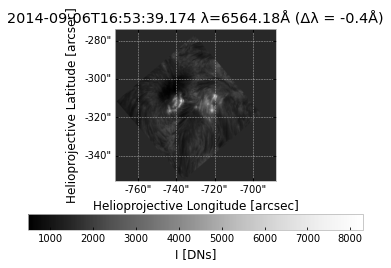

In [19]:
c[5].intensity_map()

In [4]:
c_rot, c_rot_dict = c.rotate_crop()

To correct for the seeing, we use the `mysticalman` class method for each of the types of correctors. This works by segmenting the image into 256 x 256 pixel tiles and each of these are corrected for the bad seeing before being mosaicked back together (this was a choice made in training due to limited GPU VRAM). This takes a 3D data cube as input of the format (&lambda;, y, x) and returns a cube of the same shape of the corrected data.

In [5]:
%%time
out = sc_ha.mysticalman(c_rot)

Segmenting image cube: 100%|██████████| 15/15 [00:00<00:00, 43.18it/s]


CPU times: user 5min 26s, sys: 27.2 s, total: 5min 53s
Wall time: 5min 28s


In [7]:
%%time
out_slow = c_ha.mysticalman(c_rot)

Segmenting image cube: 100%|██████████| 15/15 [00:00<00:00, 41.10it/s]


CPU times: user 5min 17s, sys: 26.3 s, total: 5min 44s
Wall time: 5min 19s


The following is the result for correcting the H&alpha; observation using both techniques. The images plotted correspond to &Delta;&lambda; = - 0.4 &#8491; from the line core of H&alpha;.

Text(0.5, 1.0, 'Corrected')

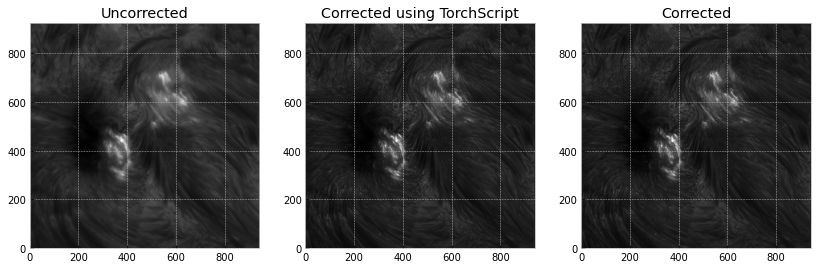

In [20]:
fig = plt.figure(figsize=(14,10))
ax1 = fig.add_subplot(1,3,1)
ax1.imshow(c_rot[5], cmap="Greys_r", origin="lower")
ax1.set_title("Uncorrected")
ax2 = fig.add_subplot(1,3,2)
ax2.imshow(out[5], cmap="Greys_r", origin="lower")
ax2.set_title("Corrected using TorchScript")
ax3 = fig.add_subplot(1,3,3)
ax3.imshow(out_slow[5], cmap="Greys_r", origin="lower")
ax3.set_title("Corrected")

Next we will demonstrate the same principal but for Ca II 8542&#8491; spectral line.

In [22]:
sc_ca = SpeedyCorrector("traced_shaun_ca8542.pt")
c_ca = Corrector(1,1,64,model_path="ca8542_final.pth")

loading model ca8542_final.pth
=> model loaded.


In [27]:
ca = CRISP("ca8542_example.fits")

/Users/john/opt/miniconda3/envs/crispy_dev/lib/python3.8/site-packages/crispy-1.0.2-py3.8.egg/crispy/crisp.py:481: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


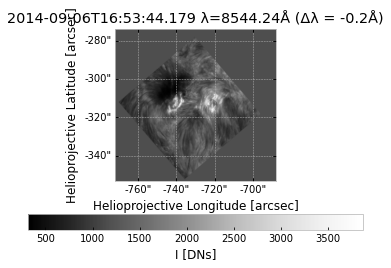

In [28]:
ca[10].intensity_map()

In [30]:
ca_rot, ca_rot_dict = ca.rotate_crop()

In [32]:
%%time
out_ca = sc_ca.mysticalman(ca_rot)

Segmenting image cube: 100%|██████████| 25/25 [00:00<00:00, 50.69it/s]


CPU times: user 9min 1s, sys: 45.2 s, total: 9min 46s
Wall time: 9min 17s


In [33]:
%%time
out_slow_ca = c_ca.mysticalman(ca_rot)

Segmenting image cube: 100%|██████████| 25/25 [00:00<00:00, 34.41it/s]


CPU times: user 8min 49s, sys: 43.5 s, total: 9min 33s
Wall time: 8min 58s


The images plotted correspond to &Delta;&lambda; = - 0.1 &#8491; from the line core of Ca II 8542&#8491;.

Text(0.5, 1.0, 'Corrected')

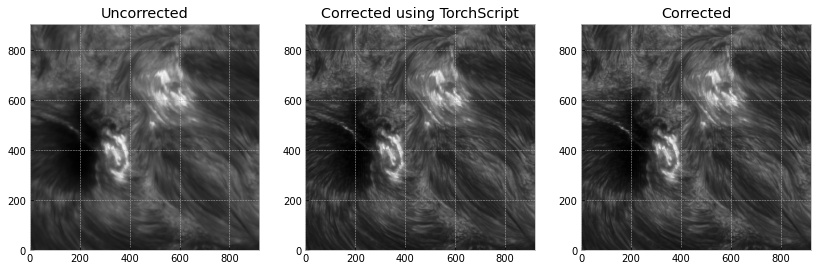

In [35]:
fig = plt.figure(figsize=(14,10))
ax1 = fig.add_subplot(1,3,1)
ax1.imshow(ca_rot[11], cmap="Greys_r", origin="lower")
ax1.set_title("Uncorrected")
ax2 = fig.add_subplot(1,3,2)
ax2.imshow(out_ca[11], cmap="Greys_r", origin="lower")
ax2.set_title("Corrected using TorchScript")
ax3 = fig.add_subplot(1,3,3)
ax3.imshow(out_slow_ca[11], cmap="Greys_r", origin="lower")
ax3.set_title("Corrected")